In [1]:
import sqlite3
import pandas as pd
import matplotlib as mpl
%matplotlib inline

In [2]:
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)

def run_command(sql):
    with sqlite3.connect('chinook.db') as conn:
        cursor = conn.cursor()
        cursor.execute(sql)

def show_tables():
    sql = "SELECT name FROM sqlite_master WHERE type='table'"
    print(run_query(sql))

In [3]:
show_tables()

              name
0            album
1           artist
2         customer
3         employee
4            genre
5          invoice
6     invoice_line
7       media_type
8         playlist
9   playlist_track
10           track


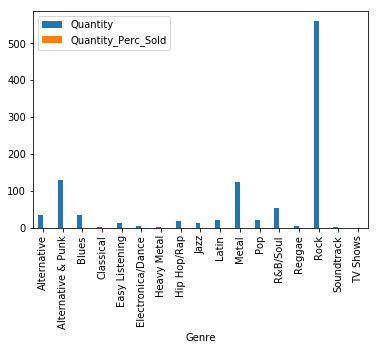

In [8]:
query1 = "SELECT g.name Genre, SUM(il.quantity) Quantity FROM genre g LEFT JOIN track t on g.genre_id = t.genre_id LEFT JOIN invoice_line il on t.track_id = il.track_id LEFT JOIN invoice i ON il.invoice_id =i.invoice_id WHERE i.billing_country = 'USA' GROUP BY g.name"
res1 = run_query(query1).set_index("Genre")
res1['Quantity_Perc_Sold'] = res1['Quantity']/res1['Quantity'].sum()
res1.plot.bar()

Based on the above query, the 3 most popular genres of music in the US are Rock, Metal, and Alternative/Punk.

       First_Name Last_Name            Hire_Date                Title    Total
EMP_ID                                                                        
3            Jane   Peacock  2017-04-01 00:00:00  Sales Support Agent  1731.51
4        Margaret      Park  2017-05-03 00:00:00  Sales Support Agent  1584.00
5           Steve   Johnson  2017-10-17 00:00:00  Sales Support Agent  1393.92


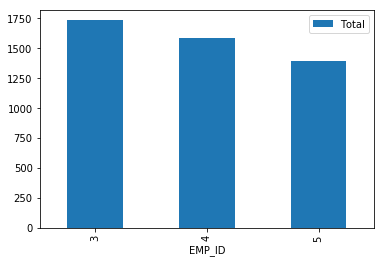

In [21]:
query2 = "SELECT e.employee_id EMP_ID, e.first_name First_Name, e.last_name Last_Name, e.hire_date Hire_Date, e.title Title, SUM(i.total) Total FROM employee e INNER JOIN customer c on e.employee_id = c.support_rep_id INNER JOIN invoice i on c.customer_id = i.customer_id GROUP BY EMP_ID"
res2 = run_query(query2).set_index("EMP_ID")
print(res2)
res2.plot.bar()

In [23]:
query3 = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(query3)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000
